# Forecasting Danube Water Levels

## Introduction
Hi! 

Welcome to the water level forecasting benchmark exercise for the Danube's measuring station "Kienstock" at km 2015.21. 

There's an official [government forecast](https://www.noel.gv.at/wasserstand/#/de/Messstellen/Details/207357/WasserstandPrognose/48Stunden) which we aim to emulate with an LSTM model. 

enjoy ;-)

## Let's load all dependencies

In [1]:
import numpy as np 
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import keras 
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
from keras.models import load_model
import h5py

import os # accessing directory structure

%matplotlib inline

Using TensorFlow backend.


Let's see if we have acces to the data file

In [2]:
# check what files we have got in our working directory
os.listdir('.')

['danube-waterlevel-Kienstock_2002-2019.csv']

In [3]:
!rm * # clear current working directory

In [4]:
!wget https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv

--2020-01-16 15:39:30--  https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190666 (186K) [text/plain]
Saving to: ‘danube-waterlevel-Kienstock_2002-2019.csv’

100%[======================================>] 190,666     --.-K/s   in 0.01s   

2020-01-16 15:39:30 (16.6 MB/s) - ‘danube-waterlevel-Kienstock_2002-2019.csv’ saved [190666/190666]



Now we're ready to read in the data.

In [5]:
nRowsRead = None # specify 'None' if want to read whole file
df1 = pd.read_csv('danube-waterlevel-Kienstock_2002-2019.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'danube-waterlevel-Kienstock_2002-2019.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 6574 rows and 4 columns


Let's take a quick look at what the data looks like:

In [6]:
df1.head(5)

Let's continue with max values only. We are looking for flood maxima after all, and min and mean are highly correlated.

In [7]:
df1 = df1.loc[:, ["date", "max"]]
df1.head(5)

,date,max
0,01.01.2002 00:00,417.0
1,02.01.2002 00:00,369.0
2,03.01.2002 00:00,329.0
3,04.01.2002 00:00,298.0
4,05.01.2002 00:00,283.0


Let's plot all data (2002 - 2019), once over time and once as histogram

Text(0, 0.5, 'max level in cm')

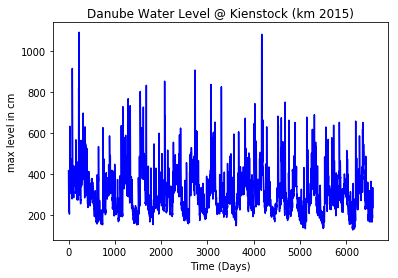

In [8]:
df1_plot = df1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df1_plot, color = 'blue') # removed ", label = 'label text'"
plt.title('Danube Water Level @ Kienstock (km 2015)')
plt.xlabel('Time (Days)')
plt.ylabel('max level in cm')
# plt.legend()
# plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88b1585208>]],
      dtype=object)

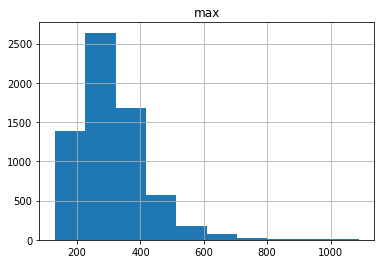

In [9]:
df1.hist()

Now let's see if we have any missing data

In [10]:
missing_data = df1.isnull()

In [11]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

date
False    6574
Name: date, dtype: int64

max
False    6573
True        1
Name: max, dtype: int64



We replace the few NaNs with the mean of the neighbors

In [12]:
for i in range (0, len(df1)):
    if missing_data.iloc[i,1]:
        df1.iloc[i,1] = (df1.iloc[i-1,1] + df1.iloc[i+1,1]) / 2
        print(i, df1.iloc[i,1])

5070 151.5


Next we have to prepare the data sets with windows for training and test

In [13]:
# defining our parameters
test_share = 0.1 # test set share of data set
timesteps = 2 # window size for LSTM
lr_timesteps = min(3, timesteps) # window size for LinReg, should not be higher than timesteps
batchsize = 4 # for LSTM

In [14]:
# setting data set lengths
print(f'nRow: {nRow}')# total data set size
max_train = int(nRow * (1 - test_share))
length_train = max_train - 2 * timesteps # subtract window size (twice for LSTM training)
length_train = length_train - int(length_train % batchsize) # training set size must be multiples of batchsize
nBatch_train = length_train / batchsize
upper_train = length_train + 2 * timesteps
print(f'upper_train: {upper_train}')
print(f'length_train: {length_train}')
print(f'nBatch_train: {nBatch_train}')

max_test = nRow - upper_train
length_test = max_test - timesteps # subtract window size
length_test = length_test - int(length_test % batchsize) # training set size must be multiples of batchsize
nBatch_test = length_test / batchsize
upper_test = length_test + timesteps
print(f'upper_test: {upper_test}')
print(f'length_test: {length_test}')
print(f'nBatch_test: {nBatch_test}')

nRow: 6574
upper_train: 5916
length_train: 5912
nBatch_train: 1478.0
upper_test: 658
length_test: 656
nBatch_test: 164.0


In [15]:
# creating data sets with feature scaling between 0 and 1.

sc = MinMaxScaler(feature_range = (0, 1))
total_set = df1.iloc[:,1:2].values
total_set_scaled = sc.fit_transform(np.float64(total_set))

training_set = total_set[0:upper_train]
print(training_set.shape)
# print(training_set_scaled[0:3])

training_set_scaled = total_set_scaled[0:upper_train]
print(training_set_scaled.shape)
# print(training_set_scaled[0:3])

test_set = total_set[upper_train:upper_train+upper_test]
print(test_set.shape)
# print(test_set[0:3])

test_set_scaled = total_set_scaled[upper_train:upper_train+upper_test]
print(test_set_scaled.shape)
# print(test_set_scaled[0:3])

(5916, 1)
(5916, 1)
(658, 1)
(658, 1)


In [16]:
# Real water levels for comparison to predictions

y_train = training_set[timesteps:length_train+timesteps]
print(y_train.shape)
# print(y_train[:3])
y_test = test_set[timesteps:length_test+timesteps]
print(y_test.shape)  
# print(y_test[:3])

(5912, 1)
(656, 1)


## A trivial prediction is the previous day's value

In [17]:
triv_y_test_pred = test_set[timesteps-1:length_test+timesteps-1]
print(triv_y_test_pred.shape)

(656, 1)


In [18]:
# calculate mean squared error on the trivial predictions
triv_residuals = triv_y_test_pred - y_test
triv_mae = np.sum(np.fabs(triv_residuals)) / len(triv_residuals)
triv_rmse = np.sqrt(np.sum(np.power(triv_residuals,2)) / len(triv_residuals))
print('Trivial test MAE: ', triv_mae)
print('Trivial test RMSE:', triv_rmse)

Trivial test MAE:  19.771341463414632
Trivial test RMSE: 34.89011496041851


## Next we set a baseline with Linear Regression

In [19]:
# Creating training data structures with windows
lr_timesteps = min(3, timesteps) # window size for LinReg, must not be larger that LSTM window size
lr_X_train_scaled = []

for i in range(timesteps, length_train+timesteps): 
    lr_X_train_scaled.append(training_set_scaled[i-lr_timesteps:i,0])

lr_X_train_scaled = np.asarray(lr_X_train_scaled)
lr_y_train_scaled = training_set_scaled[timesteps:length_train+timesteps]

print(lr_X_train_scaled.shape)
print(lr_y_train_scaled.shape)

(5912, 2)
(5912, 1)


In [20]:
# Creating test data structures
lr_X_test_scaled = []

for i in range(timesteps, length_test+timesteps): 
    lr_X_test_scaled.append(test_set_scaled[i-lr_timesteps:i,0])

lr_X_test_scaled = np.asarray(lr_X_test_scaled)

print(lr_X_test_scaled.shape)

(656, 2)


In [21]:
# do the LinReg fit
lr_model = LinearRegression()
lr_model.fit(lr_X_train_scaled, lr_y_train_scaled)
# the regression coefficients
print ('Coefficients: ', lr_model.coef_)

Coefficients:  [[-0.30002795  1.20821005]]


In [22]:
# get predicted data on the training set (for the visualization)
lr_y_train_pred_scaled = lr_model.predict(lr_X_train_scaled) 
print(lr_y_train_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lr_y_train_pred = sc.inverse_transform(lr_y_train_pred_scaled)
print(lr_y_train_pred.shape)

(5912, 1)
(5912, 1)


In [23]:
# calculate mean squared error on the training set predictions
lr_train_residuals = lr_y_train_pred - y_train
lr_train_mae = np.sum(np.fabs(lr_train_residuals)) / len(lr_train_residuals)
lr_train_rmse = np.sqrt(np.sum(np.power(lr_train_residuals,2)) / len(lr_train_residuals))
print('LinReg training MAE', lr_train_mae)
print('LinReg training RMSE', lr_train_rmse)

LinReg training MAE 20.730928313844235
LinReg training RMSE 38.430618692534274


In [24]:
# get predicted data on the test set
lr_y_test_pred_scaled = lr_model.predict(lr_X_test_scaled)
print(lr_y_test_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lr_y_test_pred = sc.inverse_transform(lr_y_test_pred_scaled)

print(lr_y_test_pred.shape)

(656, 1)
(656, 1)


In [25]:
# calculate mean squared error on the test set predictions
lr_test_residuals = lr_y_test_pred - y_test
lr_test_mae = np.sum(np.fabs(lr_test_residuals)) / len(lr_test_residuals)
lr_test_rmse = np.sqrt(np.sum(np.power(lr_test_residuals,2)) / len(lr_test_residuals))
print('LinReg test MAE: ', lr_test_mae)
print('LinReg test RMSE: ', lr_test_rmse)
print('LinReg training MAE', lr_train_mae)
print('LinReg training RMSE', lr_train_rmse)
print('Trivial test MAE: ', triv_mae)
print('Trivial test RMSE:', triv_rmse)

LinReg test MAE:  19.965632505113344
LinReg test RMSE:  32.86084014760473
LinReg training MAE 20.730928313844235
LinReg training RMSE 38.430618692534274
Trivial test MAE:  19.771341463414632
Trivial test RMSE: 34.89011496041851


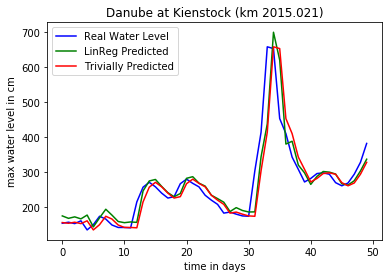

In [26]:
# Visualising the results
lo = 250
hi = min(300, len(y_test))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lr_y_test_pred[lo:hi], color = 'green', label = 'LinReg Predicted')
plt.plot(triv_y_test_pred[lo:hi], color = 'red', label = 'Trivially Predicted')
plt.title('Danube at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

## And now let's go for LSTM

In [27]:
# Creating training data structures with windows
lstm_X_train_scaled = []
lstm_Y_train_scaled = []

for i in range(timesteps, length_train+timesteps): 
    lstm_X_train_scaled.append(training_set_scaled[i-timesteps:i,0])
    lstm_Y_train_scaled.append(training_set_scaled[i:i+timesteps,0])

lstm_X_train_scaled = np.asarray(lstm_X_train_scaled)
lstm_Y_train_scaled = np.asarray(lstm_Y_train_scaled)
lstm_X_train_scaled = np.reshape(lstm_X_train_scaled, (lstm_X_train_scaled.shape[0], lstm_X_train_scaled.shape[1], 1))
lstm_Y_train_scaled = np.reshape(lstm_Y_train_scaled, (lstm_Y_train_scaled.shape[0], lstm_Y_train_scaled.shape[1], 1))

print(lstm_X_train_scaled.shape)
# print(lstm_X_train_scaled[:2])
print(lstm_Y_train_scaled.shape)
# print(lstm_Y_train_scaled[:2])

(5912, 2, 1)
(5912, 2, 1)


In [28]:
# Creating test data structures
lstm_X_test_scaled = []

for i in range(timesteps, length_test+timesteps): 
    lstm_X_test_scaled.append(test_set_scaled[i-timesteps:i,0])

lstm_X_test_scaled = np.asarray(lstm_X_test_scaled)
lstm_X_test_scaled = np.reshape(lstm_X_test_scaled, (lstm_X_test_scaled.shape[0], lstm_X_test_scaled.shape[1], 1))

print(lstm_X_test_scaled.shape)
# print(lstm_X_test_scaled[0:3])    

(656, 2, 1)


In [29]:
# Initialising the LSTM Model with MSE Loss-Function using Functional API

inputs_1 = Input(batch_shape=(batchsize,timesteps,1))
lstm_1 = LSTM(3, stateful=True, return_sequences=True)(inputs_1)
output_1 = Dense(units = 1)(lstm_1)

lstm_reg = Model(inputs=inputs_1, outputs = output_1)

#adam is fast starting off and then gets slower and more precise
#mse -> mean sqare error loss function
lstm_reg.compile(optimizer='adam', loss = 'mse')
lstm_reg.summary()

W0116 15:40:27.335023 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0116 15:40:27.368413 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0116 15:40:27.372528 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0116 15:40:27.641920 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (4, 2, 1)                 0         
_________________________________________________________________
lstm_1 (LSTM)                (4, 2, 3)                 60        
_________________________________________________________________
dense_1 (Dense)              (4, 2, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [30]:
epochs = 30

#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    lstm_reg.fit(lstm_X_train_scaled, lstm_Y_train_scaled, shuffle=False, epochs = 1, batch_size = batchsize)
    #resets only the states but the weights, cell and hidden are kept.
    lstm_reg.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

W0116 15:40:29.316190 140226305972032 deprecation.py:323] From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0


W0116 15:40:29.827952 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0116 15:40:29.919042 140226305972032 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0151
Epoch: 1
Epoch 1/1
5912/5912 [==============================] - 13s 2ms/step - loss: 0.0080
Epoch: 2
Epoch 1/1
5912/5912 [==============================] - 13s 2ms/step - loss: 0.0066
Epoch: 3
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0059
Epoch: 4
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0056
Epoch: 5
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0054
Epoch: 6
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0053
Epoch: 7
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0052
Epoch: 8
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0051
Epoch: 9
Epoch 1/1
5912/5912 [==============================] - 14s 2ms/step - loss: 0.0049
Epoch: 10
Epoch 1/1
5912/5912 [==============================] - 13s 2ms/step - loss: 0.0

In [31]:
# get predicted data on the test set

lstm_Y_test_pred_scaled = lstm_reg.predict(lstm_X_test_scaled, batch_size=batchsize)
lstm_reg.reset_states()
print(lstm_Y_test_pred_scaled.shape)

lstm_y_test_pred_scaled = lstm_Y_test_pred_scaled[:,-1,:] # keep only value of last timestep
print(lstm_y_test_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lstm_y_test_pred = sc.inverse_transform(lstm_y_test_pred_scaled)

(656, 2, 1)
(656, 1)


In [32]:
# calculate mean squared error on the test set predictions
lstm_test_residuals = lstm_y_test_pred - y_test
lstm_test_mae = np.sum(np.fabs(lstm_test_residuals)) / len(lstm_test_residuals)
lstm_test_rmse = np.sqrt(np.sum(np.power(lstm_test_residuals,2)) / len(lstm_test_residuals))
print('LSTM test MAE: ', lstm_test_mae)
print('LSTM test RMSE: ', lstm_test_rmse)
print('LinReg test MAE: ', lr_test_mae)
print('LinReg test RMSE: ', lr_test_rmse)
print('Trivial test MAE: ', triv_mae)
print('Trivial test RMSE: ', triv_rmse)

LSTM test MAE:  28.049030420256823
LSTM test RMSE:  39.11376017247348
LinReg test MAE:  19.965632505113344
LinReg test RMSE:  32.86084014760473
Trivial test MAE:  19.771341463414632
Trivial test RMSE:  34.89011496041851


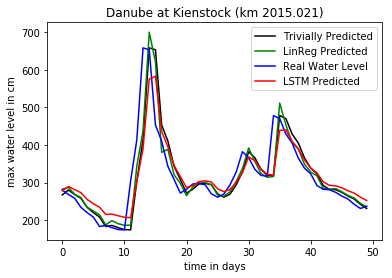

In [38]:
# Visualising the results
lo = 270
hi = min(320, len(y_test))
plt.plot(triv_y_test_pred[lo:hi], color = 'black', label = 'Trivially Predicted')
plt.plot(lr_y_test_pred[lo:hi], color = 'green', label = 'LinReg Predicted')
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88b02c6390>]],
      dtype=object)

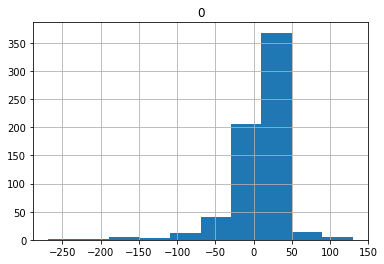

In [34]:
pd.DataFrame(lstm_test_residuals).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a82fb4e0>]],
      dtype=object)

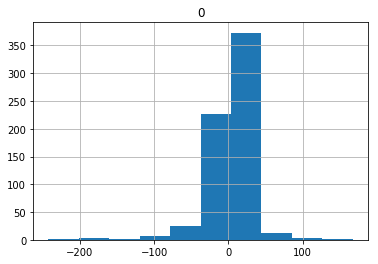

In [40]:
pd.DataFrame(lr_test_residuals).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a81445c0>]],
      dtype=object)

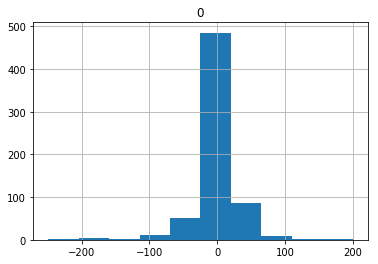

In [41]:
pd.DataFrame(triv_residuals).hist()

So, what did we learn? The trivial prediction performs rather well, surprisingly.